In [1]:
import numpy as np
from scipy.linalg import expm
from random import sample, shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
Gamma_to_sink=5.

#System evolution
def evolve(r0, H, t):
    N_in=H.shape[0]
    
    I=np.eye(N_in, dtype="complex64")
    sm=np.zeros([N_in,N_in], dtype="complex64")
    sm[0,2]=1
    sp=np.zeros([N_in,N_in], dtype="complex64")
    sp[2, 0]=1
    
    L_uni=np.kron(I, H)-np.kron(H.transpose().conjugate(), I)
    L_sink=Gamma_to_sink*(2*np.kron(sp.transpose(), sm)-np.kron(I, sp@sm)-np.kron((sp@sm).transpose().conjugate(), I))
    return (expm((1j*L_uni+L_sink)*t)@r0).real[0]


#Chain class
class QNetwork:
    def __init__(self, J0=1., T=1., N_max=11):
        self.J=J0
        self.T=T
        self.DE=1.
        self.N_max=N_max
        
        self.nodes_coordinates=np.zeros(self.N_max)
        self.nodes_coordinates[0]=1.
        self.nodes_coordinates[-1]=1.
        self.nodes_positions=[np.array([-1.]), np.array([0.]), np.array([1.])]
   
        self.H=np.zeros([3,3], dtype="complex64")
        self.H[1,1]=self.DE
        self.H[2,2]=self.DE
        self.H[1,2]=self.J
        self.H[2,1]=self.J
        self.rho0=np.zeros([3,3])
        self.rho0[1,1]=1
        self.rho0=self.rho0.reshape(9)
    
    #Interactions
    def H_ij(self, x_i, x_j):
        return self.J/((np.linalg.norm(x_j-x_i))**3)
    
    #Add new node to the chain and update Hamiltonian and state
    def add_node(self, nx):
        self.nodes_coordinates[nx]=1.
        x=float(nx)/(self.N_max-1)
        
        id_last=self.H.shape[0]
        H_new = self.H.copy()
        H_new=np.vstack((np.hstack((H_new, np.zeros([id_last,1], complex))), np.zeros([1,id_last+1], complex)))
        for i in range(1, id_last):
            H_new[id_last,i]=self.H_ij(x, self.nodes_positions[i])
            H_new[i, id_last]=H_new[id_last,i]
        H_new[id_last, id_last]=self.DE
        
        rho0=np.zeros([id_last+1, id_last+1])
        rho0[1,1]=1
        rho0=rho0.reshape((id_last+1)**2)
        
        self.rho0=rho0
        self.nodes_positions+=[np.array(x)]
        self.H=H_new
        
    #FOR REINFORCEMENT LEARNING
    #Reset chain to the original configuration
    def reset(self):
        self.nodes_coordinates=np.zeros(self.N_max)
        self.nodes_coordinates[0]=1.
        self.nodes_coordinates[-1]=1.
        self.nodes_positions=[np.array([-1.]), np.array([0.]), np.array([1.])]
   
        self.H=np.zeros([3,3], dtype="complex64")
        self.H[1,1]=self.DE
        self.H[2,2]=self.DE
        self.H[1,2]=self.J
        self.H[2,1]=self.J
        self.rho0=np.zeros([3,3])
        self.rho0[1,1]=1
        self.rho0=self.rho0.reshape(9)
        return self.nodes_coordinates
    
    #MDP step
    def step(self, action):
        terminated=False
        if self.nodes_coordinates[action]<1:
            r0 = evolve(self.rho0, self.H, self.T)
            self.add_node(action)
            r1 = evolve(self.rho0, self.H, self.T)
            reward = r1 - r0
            if r1>0.99: terminated = True
        else:
            reward = 0.
            #terminated = True
        
        return self.nodes_coordinates, reward, terminated

In [3]:
eps=1e-10

#Physical parameters
N=21
J0=0.05
T=5.

#environment
num_obs = N
num_acts = N
max_steps_per_episode=11

#learning
gamma=0.99
lmbda = 0.95
num_agents = 100
num_epochs = 4
batchsize = 128
#cS = 0.001

clip_ratio = 0.2
kinit = tf.keras.initializers.HeUniform()
loss_function = keras.losses.Huber() #MeanSquaredError() #

lr_actor = 1e-4
optimizer_actor = keras.optimizers.Adam(learning_rate=lr_actor)

lr_critic= 1e-4
optimizer_critic = keras.optimizers.Adam(learning_rate=lr_critic)


#Actor
inputs_act = layers.Input(shape=(num_obs,))
hid_act = layers.Dense(128, activation="relu", kernel_initializer=kinit)(inputs_act)
hid_act = layers.Dense(128, activation="relu", kernel_initializer=kinit)(hid_act)
output_act = layers.Dense(num_acts, activation="softmax")(hid_act)
actor = keras.Model(inputs=inputs_act, outputs=output_act)

#Critic
inputs_crit = layers.Input(shape=(num_obs,))
hid_crit = layers.Dense(64, activation="relu", kernel_initializer=kinit)(inputs_crit)
hid_crit = layers.Dense(64, activation="relu", kernel_initializer=kinit)(hid_crit)
output_crit = layers.Dense(1, activation="linear")(hid_crit)
critic = keras.Model(inputs=inputs_crit, outputs=output_crit)

#Initialize
opt=[]
current_max=-100

env = QNetwork(J0, T, N)

In [4]:
def preprocess(states, actions, rewards, done, values): 
    g = 0
    returns = []
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * values[i + 1] * done[i] - values[i]
        g = delta + gamma * lmbda * done[i] * g
        returns.append(g + values[i])

    returns.reverse()
    adv = np.array(returns, dtype=np.float32) - values[:-1]
    return returns, adv.tolist()

def learn_epoch(states, actions, advs, old_probs, returns):
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            probs = actor(states)
            values = critic(states)
            L_clip = -sum([min(advs[batch]*probs[batch][actions[batch]]/old_probs[batch][actions[batch]], tf.clip_by_value(probs[batch][actions[batch]]/old_probs[batch][actions[batch]], 1.-clip_ratio, 1.+clip_ratio)*advs[batch]) for batch in range(batchsize)])/batchsize
            L_crit = loss_function(values, returns.astype("float32"))
            #L_entropy = -sum([-tf.tensordot(probs[batch], tf.math.log(probs[batch]+eps), axes=1) for batch in range(batchsize)])/batchsize
         
                
            grads1 = tape1.gradient(L_clip, actor.trainable_variables) #+cS*L_entropy
            grads2 = tape2.gradient(L_crit, critic.trainable_variables)
        
            optimizer_actor.apply_gradients(zip(grads1, actor.trainable_variables))
            optimizer_critic.apply_gradients(zip(grads2, critic.trainable_variables))
    
    return L_clip.numpy(), L_crit.numpy(), 0#cS*L_entropy.numpy()

In [6]:
actions_history = []
states_history = []
advs_history = []
returns_history = []
probs_history = []

test_performance = []

num_episodes = 1000
episode_count = 0

while True:
    opt_rew=-100
    performance_episode = 0
    for agent in range(num_agents):
        actions_agent = []
        states_agent = []
        values_agent = []
        done_agent = []
        rewards_agent = []
        probs_agent = []
        
        state=env.reset()
        for timestep in range(1, max_steps_per_episode):
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = actor(state_tensor, training=False)
            critic_values = critic(state_tensor, training=False)
            action = np.random.choice(num_acts, p=np.squeeze(action_probs))
            
            state_next, reward, done = env.step(action)
            state_next = np.array(state_next, dtype=np.float32)
            
            probs_agent.append(np.squeeze(action_probs))
            actions_agent.append(action)
            states_agent.append(state)
            values_agent.append(critic_values.numpy()[0][0])
            done_agent.append(1-done)
            rewards_agent.append(reward)
            state = state_next
            
            performance_episode+=reward
            if reward>opt_rew: opt_rew=reward
            
            if done:
                break
                
        final_pops = evolve(env.rho0, env.H, env.T)
        if final_pops > current_max:
            current_max = final_pops
            opt = env.nodes_coordinates
                
        values_agent.append(0.)
            
        returns_agent, advs_agent = preprocess(states_agent, actions_agent, rewards_agent, done_agent, values_agent)
        
        actions_history += actions_agent
        states_history += states_agent
        returns_history += returns_agent
        advs_history += advs_agent
        probs_history += probs_agent
        
    #advs_history = ((np.array(advs_history) - np.array(advs_history).mean())/np.array(advs_history).std()).tolist()
    test_performance += [performance_episode/(num_agents)]
    
    lossA = 0
    lossC = 0
    lossS = 0
    for epoch in range(num_epochs):
        indices = np.random.choice(range(len(returns_history)), size=batchsize)
        states_sample = np.array([states_history[i] for i in indices])
        actions_sample = np.array([actions_history[i] for i in indices])
        probs_sample = np.array([probs_history[i] for i in indices])
        returns_sample = np.array([returns_history[i] for i in indices])
        advs_sample = np.array([advs_history[i] for i in indices])
        lossA_epoch, lossC_epoch, lossS_epoch = learn_epoch(states_sample, actions_sample, advs_sample, probs_sample, returns_sample)
        lossA += lossA_epoch/num_epochs
        lossC += lossC_epoch/num_epochs
        lossS += lossS_epoch/num_epochs
    
    max_prob = probs_history[0].max()
    
    actions_history.clear()
    states_history.clear()
    returns_history.clear()
    advs_history.clear()
    probs_history.clear()
    
    state=env.reset()
    for timestep in range(1, max_steps_per_episode):
        state_tensor = tf.convert_to_tensor(state)
        state_tensor = tf.expand_dims(state_tensor, 0)
        action_probs = actor(state_tensor, training=False)
        critic_values = critic(state_tensor, training=False)
        action = np.argmax(np.squeeze(action_probs))
        state_next, reward, done = env.step(action)
        state_next = np.array(state_next, dtype=np.float32)
        state=state_next
        if done: break    
    final_pops = evolve(env.rho0, env.H, env.T)
    
    print(episode_count, current_max, final_pops, opt_rew, max_prob, lossC, test_performance[-1])
    
    episode_count+= 1   
    if episode_count>num_episodes:
        break

0 0.4940678345661837 0.7412506341753483 0.9294051050366872 0.1089342 0.42159493267536163 0.015923509392716504
1 0.4940678345661837 0.7412506341753483 0.8348536117429656 0.108662054 0.41234003007411957 0.009908453036509677
2 0.9465823617514226 0.7412506341753483 0.9349068896980209 0.10892604 0.44339726120233536 0.034355786093364135
3 0.9987517717781892 0.7412506341753483 0.9271648573973735 0.10949947 0.34226571023464203 0.04101430285264172
4 0.9987517717781892 0.7412506341753483 0.9349068896979909 0.10934177 0.3486957624554634 0.019792052531810166
5 0.9987517717781892 0.7412506341753483 0.9379879255788528 0.108975396 0.3394121751189232 0.02263022228261498
6 0.9987517717781892 0.7412506341753483 0.9194860770217237 0.108976014 0.2717202305793762 0.031669497595212016
7 0.9987517717781892 0.7412506341753483 0.946875314951464 0.10913615 0.2747788354754448 0.01626028205079774
8 0.9987517717781916 0.7412506341753483 0.9194860770217237 0.109678626 0.21683798357844353 0.0448720662355728
9 0.9987

74 0.9987517717781916 0.7412506341753483 0.9064172816376506 0.09922552 0.03451317874714732 0.0028913662833468697
75 0.9987517717781916 0.7412506341753483 0.9143112107359124 0.09944519 0.042771827429533005 0.010725122157201908
76 0.9987517717781916 0.7412506341753483 0.9379879255788528 0.09962277 0.03993907570838928 0.02301352538576159
77 0.9987517717781916 0.7412506341753483 0.9503961320362504 0.099746436 0.034552667289972305 0.021497309276064986
78 0.9987517717781916 0.7412506341753483 0.8857960482484812 0.099594824 0.02813661191612482 0.03352611105005344
79 0.9987517717781916 0.7412506341753483 0.8737774050426896 0.09926961 0.035334281623363495 0.016275114845762207
80 0.9987517717781916 0.7412506341753483 0.9194860770217237 0.09930601 0.03902593906968832 0.03605338462082066
81 0.9987517717781916 0.7412506341753483 0.8857960482484823 0.099728905 0.03114678105339408 0.02815925084844915
82 0.9987517717781916 0.7412506341753483 0.954476213103912 0.09993455 0.033810985274612904 0.02107729

147 0.9987517717781916 0.011969569062243801 0.8674793711642559 0.095432706 0.02421132754534483 0.02441957572310959
148 0.9987517717781916 0.011969569062243801 0.9123704725917726 0.09565757 0.02128228498622775 0.02661535280655454
149 0.9987517717781916 0.011969569062243801 0.9194860770217237 0.09566982 0.023661771323531866 0.011327657898748017
150 0.9987517717781916 0.011969569062243801 0.9072667712292515 0.095425226 0.022210491355508566 0.04097710009575658
151 0.9987517717781916 0.011969569062243801 0.9013630052787472 0.09503323 0.028885082341730595 0.022705241102012903
152 0.9987517717781916 0.011969569062243801 0.9046629013346121 0.09486069 0.02519590174779296 0.031722283078787876
153 0.9987517717781916 0.011969569062243801 0.9194860770217237 0.0951769 0.02813417138531804 0.020616951823207722
154 0.9987517717781916 0.011969569062243801 0.9850251170951393 0.0955391 0.028944913297891617 0.0288871325633022
155 0.9987517717781916 0.011969569062243801 0.9194860770217237 0.09511895 0.01889

219 0.998751771778193 0.011969569062243801 0.8795681523804412 0.10299628 0.017944789957255125 0.016236867045924884
220 0.998751771778193 0.011969569062243801 0.9349068896979741 0.10234029 0.02224027132615447 0.03495147123422204
221 0.998751771778193 0.011969569062243801 0.9194860770217237 0.101604104 0.01930843247100711 0.026605999222844016
222 0.998751771778193 0.011969569062243801 0.7931886982246947 0.10113309 0.015815323451533914 0.037561957490562896
223 0.998751771778193 0.011969569062243801 0.8857960482484823 0.10089779 0.019906089641153812 0.016380413475921684
224 0.998751771778193 0.011969569062243801 0.9194860770217237 0.1008234 0.01817048666998744 0.03639298080641159
225 0.998751771778193 0.011969569062243801 0.8816354394415263 0.10119105 0.021472423803061247 0.04802757734604036
226 0.998751771778193 0.011969569062243801 0.9046629013346121 0.10195147 0.022421425208449364 0.06455190116375538
227 0.998751771778193 0.011969569062243801 0.8857960482484828 0.10287832 0.025215724483

291 0.998751771778193 0.011969569062243801 0.8788218101913022 0.11809511 0.019556340761482716 0.054541268556111244
292 0.998751771778193 0.011969569062243801 0.8946718758553662 0.11907598 0.01963257184252143 0.050531720076111376
293 0.998751771778193 0.011969569062243801 0.7937477773540524 0.12005924 0.016893602907657623 0.039493655519655696
294 0.998751771778193 0.011969569062243801 0.938632989263528 0.120663226 0.017889981158077717 0.03457224414102762
295 0.998751771778193 0.011969569062243801 0.8946718758553673 0.12111462 0.01722478400915861 0.04182603702530549
296 0.998751771778193 0.011969569062243801 0.90466290133461 0.12106679 0.017329309601336718 0.025224305382753883
297 0.998751771778193 0.011969569062243801 0.9194860770217237 0.12112128 0.02198734413832426 0.057120151502106815
298 0.998751771778193 0.011969569062243801 0.9046629013346121 0.121375464 0.014812985435128212 0.05884011707792803
299 0.998751771778193 0.011969569062243801 0.9269709615305666 0.12125636 0.020969048608

364 0.998751771778193 0.0023150434780763083 0.946875314951463 0.14715779 0.034998693969100714 0.13940906411615425
365 0.998751771778193 0.0023150434780763083 0.9454897845244907 0.14860068 0.023083113599568605 0.08679978260236254
366 0.998751771778193 0.0023150434780763083 0.9692914066128923 0.14813913 0.02950288262218237 0.10865341073012015
367 0.998751771778193 0.0023150434780763083 0.9238885923629603 0.14709894 0.028733398765325546 0.09358403562234009
368 0.998751771778193 0.0023150434780763083 0.9194860770217237 0.14754324 0.030384672340005636 0.08747120901597373
369 0.998751771778193 0.0023150434780763083 0.9194860770217237 0.14868416 0.02906069066375494 0.10957412804895593
370 0.998751771778193 0.0023150434780763083 0.894671875855367 0.1499581 0.017423756886273623 0.05328069145102514
371 0.998751771778193 0.0023150434780763083 0.969291406612892 0.15114327 0.03004743531346321 0.16364390272227136
372 0.998751771778193 0.0023150434780763083 0.9046629013346129 0.15208718 0.03404106805

438 0.998751771778193 0.10407989592282199 0.9692914066128914 0.25536016 0.06085814442485571 0.44183406973181727
439 0.998751771778193 0.10407989592282199 0.9468753149514622 0.25753957 0.08211793005466461 0.4491175754494499
440 0.998751771778193 0.10407989592282199 0.9046629013346129 0.25652492 0.07546231150627136 0.45788335650696
441 0.998751771778193 0.10407989592282199 0.9046629013346119 0.2550075 0.07506863214075565 0.5126635869913274
442 0.998751771778193 0.10407989592282199 0.9046629013346129 0.25692305 0.08543431758880615 0.600596047159908
443 0.998751771778193 0.10407989592282199 0.9692914066128974 0.25675824 0.07769611105322838 0.5708037218487295
444 0.998751771778193 0.0023150434780763083 0.9468753149514632 0.25938335 0.07253944128751755 0.48455364895378844
445 0.998751771778193 0.0023150434780763083 0.9468753149514639 0.2657288 0.07807374000549316 0.5265500035116061
446 0.998751771778193 0.0023150434780763083 0.9046629013346129 0.27452442 0.07544882036745548 0.527928231832600

513 0.998751771778193 0.9987517717781906 0.9046629013346129 0.27816677 0.05097613949328661 0.9263199573144222
514 0.998751771778193 0.9987517717781906 0.9046629013346129 0.27398843 0.0497675035148859 0.8955214510585543
515 0.998751771778193 0.9987517717781906 0.9046629013346129 0.27209756 0.03905279282480478 0.9342113314668015
516 0.998751771778193 0.9987517717781906 0.9046629013346129 0.2711136 0.05332331545650959 0.9468340325017982
517 0.998751771778193 0.9987517717781906 0.9046629013346129 0.26542324 0.05510921590030193 0.9141966936842972
518 0.998751771778193 0.9987517717781906 0.946875314951464 0.2604616 0.057171477004885674 0.9086182096242607
519 0.998751771778193 0.9987517717781906 0.9046629013346129 0.2573144 0.04578524176031351 0.9208751143028994
520 0.998751771778193 0.9987517717781906 0.9468753149514632 0.25964153 0.045352946035563946 0.9266417335194913
521 0.998751771778193 0.9987517717781906 0.9692914066128974 0.26455924 0.04611125402152538 0.9237822759379543
522 0.9987517

588 0.998751771778193 0.9987517717781906 0.9046629013346121 0.31779635 0.05867768544703722 0.9597614439712764
589 0.998751771778193 0.9987517717781906 0.9046629013346129 0.30927455 0.02776761306449771 0.980568015232557
590 0.998751771778193 0.9987517717781906 0.9046629013346129 0.30261487 0.03512097802013159 0.9715043467823159
591 0.998751771778193 0.9987517717781906 0.9046629013346129 0.29818973 0.042426424100995064 0.9503380794428122
592 0.998751771778193 0.9987517717781906 0.9046629013346121 0.29692787 0.04278477746993303 0.9372880157843079
593 0.998751771778193 0.9987517717781906 0.9046629013346129 0.2970455 0.03983232192695141 0.9649524708857647
594 0.998751771778193 0.9987517717781906 0.9046629013346129 0.29733166 0.0422233622521162 0.9533850768356003
595 0.998751771778193 0.9987517717781906 0.9046629013346129 0.29416433 0.045182171277701855 0.9580293635006156
596 0.998751771778193 0.9987517717781906 0.9046629013346129 0.2961089 0.04151428863406181 0.9617057745031147
597 0.998751

663 0.998751771778193 0.9987517717781909 0.9046629013346129 0.28957084 0.02722849976271391 0.9904629698994519
664 0.998751771778193 0.9987517717781909 0.9046629013346121 0.2896191 0.03475898131728172 0.9744881830760996
665 0.998751771778193 0.9987517717781909 0.9046629013346129 0.29089004 0.02928747609257698 0.9863318815411855
666 0.998751771778193 0.9987517717781909 0.9046629013346129 0.2943245 0.03448672592639923 0.974916538878828
667 0.998751771778193 0.9987517717781909 0.9468753149514622 0.29732728 0.03708821116015315 0.9729552847546544


KeyboardInterrupt: 

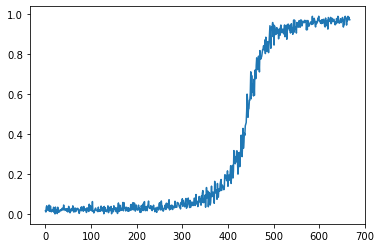

In [7]:
plt.plot(test_performance)

In [8]:
state=env.reset()
for timestep in range(1, max_steps_per_episode):
    state_tensor = tf.convert_to_tensor(state)
    state_tensor = tf.expand_dims(state_tensor, 0)
    action_probs = actor(state_tensor, training=False)
    critic_values = critic(state_tensor, training=False)
    action = np.argmax(np.squeeze(action_probs))
    state_next, reward, done = env.step(action)
    state_next = np.array(state_next, dtype=np.float32)
    state=state_next
    if done: break    
final_pops = evolve(env.rho0, env.H, env.T)
print(final_pops)

0.9987517717781909


In [9]:
print(state)

[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]


In [10]:
print(opt)

[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]


In [11]:
np.savetxt("PPOchain_grid21_J_0_05_learning.csv", np.array(test_performance), delimiter=",")

In [12]:
actor.save("PPOchain_grid21_J_0_05_actor")
critic.save("PPOchain_grid21_J_0_05_critic")

INFO:tensorflow:Assets written to: PPOchain_grid21_J_0_05_actor\assets
INFO:tensorflow:Assets written to: PPOchain_grid21_J_0_05_critic\assets
